In [83]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math
from math import inf
from datetime import datetime,timedelta
import calendar
import warnings

1984 extent: 3251 meters
This was calculated by measuring the length of the glacier along the centerline on a polygon of the glacier from 1958. Then extent change date from FoG_FVobs_205.csv was used to calculate the change in extent from 1958-1984

In [84]:
class glacierSim():
    def __init__(self, ela=1880,valley_length=3668, time=500,save=10,gamma=0.01,quiet=True, tune_factors=[0.00006,0.00006,0.00001,15,0.00003,0.00003], initial_ice=None, start_time=0):
        #tunefactors=[ice, snow, accum]
        #print("OBJ INIT")
        self.valley_length = valley_length
        self.run_time=start_time*365.25 #DAYS
        self.prev_display=0
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.num_cells = 50 #set number of cells
        self.dx = self.valley_length/(self.num_cells-1) #cell width in m
        self.time = time #simulation time in years
        self.current_date=datetime(984,1,1)+timedelta(days=start_time*365.25)
        self.save = save*365.25 #timestep interval in days
        self.frames = ((int)((self.time-start_time)/(self.save/365.25)))+1 #number of frames the animation will run for
        if start_time==0: self.ice = np.zeros(self.num_cells) #initialize ice
        else: self.ice = np.array(initial_ice)
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.x = np.linspace(0.5 * self.dx, self.valley_length - 0.5 * self.dx,self.num_cells) #used for plotting topography and ice thickness
        self.topo =[] #initialize topography
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.b_max = float(-inf)
        self.b_min = float(inf)
        self.gamma = gamma #for mass balance equation
        self.ice_volume=0
        self.snow_melt_vol=0
        self.volume_change=[]
        self.yearly_volume_change=np.zeros(41)
        self.daily_volume_change=np.zeros(180)
        self.volume_valid=[]
        self.prev_volume=0
        self.initial_volume=0
        self.timestep_list=[] #days
        self.initial_run=False
        self.b=np.zeros(self.num_cells)
        self.glacier_extent=0
        self.snow_depth=np.zeros(self.num_cells)
        self.ice_slope = np.zeros(self.num_cells, dtype=np.longdouble) #initialize ice_slope
        self.quiet=quiet
        self.dates=[]
        self.temps=[]
        self.precip=[]
        self.annual_mb=[]
        self.winter_mb=[]
        self.summer_mb=[]
        self.bins=[]
        self.years=[]
        self.ela_list=[]
        self.areas=[]
        self.calculated_annual_mb=np.zeros(40, dtype=np.float64)
        self.calculated_winter_mb=np.zeros(40, dtype=np.float64)
        self.calculated_summer_mb=np.zeros(40, dtype=np.float64)
        self.mb_arr=np.zeros(len(self.b))
        self.thickness_change_verif=np.zeros(4)
        self.thickness_change=np.zeros(4)
        self.thickness_1986_verif=0
        self.ice_1986=np.zeros(self.num_cells)
        self.front_variation_verif=np.zeros(100)
        self.front_variation_calc=np.zeros(100)
        self.ela_verif=np.zeros(100)
        self.prev_thickness=np.mean(self.ice)
        self.prev_front=np.max(self.x[self.ice>1]) if np.any(self.ice>1) else 0
        self.ice_melt_factor=tune_factors[0]
        self.snow_melt_factor=tune_factors[1]
        self.accum_factor=tune_factors[2]
        self.snow_conv_factor=tune_factors[3]
        self.snow_melt_amplitude=tune_factors[4]
        self.ice_melt_amplitude=tune_factors[5]
        self.widths=np.zeros(self.num_cells)
        self.widths_over_time=[]
        self.ice_thickness_over_time=[]
        self.date_index=np.zeros(100)
        self.ice_line_list=[]
        self.snow_line_list=[]
        self.ela_line_list=[]
        self.title_list=[]
    
    def init(self, ax,ela=6700,valley_length=3668, time=500,save=10,gamma=0.008, quiet=True, tune_factors=[0.00006,0.00006,0.00001,15,0.00003,0.00003], initial_ice=None, start_time=0):
        self.__init__(ela, valley_length, time, save, gamma, quiet, tune_factors, initial_ice, start_time)
        self.load_verif_data()
        self.calc_topo()
        self.calc_widths()
        self.load_mb_data()
        try: curr_ela=self.topo[np.where((self.b[:-1] >= 0) & (self.b[1:] < 0))[0]][0]
        except: curr_ela=self.topo[-1]
        self.ela_list.append(curr_ela)

[2100.         2070.27007916 2040.54015833 2016.09853476 1989.45227235
 1962.08878604 1937.53755595 1904.30054015 1881.49059875 1865.34259034
 1854.82236249 1852.37684226 1851.48500043 1846.3817158  1837.11618878
 1817.86790617 1791.65000239 1757.9647862  1753.46646002 1758.23169415
 1751.77460359 1744.53847947 1736.70557995 1726.39686463 1715.54049309
 1699.78722371 1684.74131675 1672.18826359 1661.93565154 1655.72663302
 1659.09155693 1672.12913635 1680.371386   1685.4215386  1676.76121511
 1662.61896595 1655.2180387  1649.11430975 1646.33547828 1642.42871901
 1628.47412181 1626.0084061  1623.54269038 1621.07697467 1618.61125895
 1616.14554323 1614.69711505 1614.13141003 1613.56570502 1613.        ]


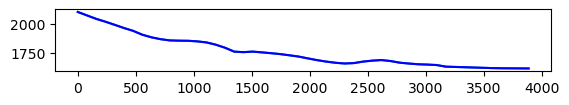

In [85]:

class glacierSim(glacierSim):
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        #print("CALC TOPO")
        latitudes = []
        longitudes = []
        topo = []
        df = pd.read_csv('Data/centerlineBed.csv')
        latitudes = df.iloc[:, 2].astype(float).tolist()  # Latitude is the second column (index 2)
        longitudes = df.iloc[:, 1].astype(float).tolist()  # Longitude is the third column (index 1)
        topo = df.iloc[:, 0].astype(float).tolist()  # Elevation is the first column (index 0)
        cumulative_distances=[0.0]
        for i in range(1, len(latitudes)): cumulative_distances.append(cumulative_distances[-1] + self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) )
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells)
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, topo)
        self.valley_length=np.max(self.x)
        self.dx = self.valley_length/(self.num_cells-1)
        self.default_b = True
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx))
        #self.ice=np.exp(-0.5 * ((self.x - 700) / 300) ** 2)
        #scale=300/np.max(self.ice)
        #self.ice*=scale
        self.ice_volume=np.sum(self.ice*self.widths*self.dx)
        self.initial_volume=self.ice_volume
        self.prev_volume=self.ice_volume.copy()
        self.volume_change.append(self.initial_volume)
        self.thickness_1986_verif=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_1986_verif) if type(self.thickness_1986_verif) is not int else np.zeros(self.num_cells)
        
    def calc_widths(self):
        df = pd.read_csv('Data/Input_SouthCascade_Area_Altitude_Distribution.csv')
        self.bins = df.columns[1:].astype(float).to_numpy()
        self.years = df.iloc[:, 0].astype(float).tolist()
        self.areas = df.iloc[:, 1:].astype(float).values*1000000
        self.bins=np.append(self.bins, self.bins[-1]+50)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            self.widths = np.array(self.areas[0,:]/np.abs(np.diff(self.x[np.array([np.argmin(np.abs(self.topo+self.ice - bin_value)) for bin_value in self.bins])])))[np.searchsorted(self.bins, (self.topo+self.ice))]
        self.widths[np.isinf(self.widths)]=0
                
    def update_widths(self):
        prev_width=self.widths
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            self.widths = np.array(self.areas[(self.current_date.year-1950),:]/np.abs(np.diff(self.x[np.array([np.argmin(np.abs(self.topo+self.ice - bin_value)) for bin_value in self.bins])])))[np.clip((np.searchsorted(self.bins, (self.topo+self.ice))),0,(len(self.areas[0])-1))]
        self.widths[np.isinf(self.widths)]=0
        if np.abs(self.widths-prev_width).any()>0:
            self.widths_over_time.append(self.widths.copy())
            self.ice_thickness_over_time.append(self.ice.copy())
        
glac=glacierSim()
glac.calc_topo()
glac.calc_widths()
print(glac.topo)
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo, color='b')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [86]:
class glacierSim(glacierSim):
    def load_mb_data(self):
        df = pd.read_csv('Data/Input_SouthCascade_Daily_Weather.csv')
        self.dates = pd.to_datetime(df.iloc[:, 0], format="%Y/%m/%d").tolist()
        self.temps = df.iloc[:, 1].astype(float).to_numpy()
        self.precip = df.iloc[:, 2].apply(lambda x: float(x) if not np.isnan(float(x)) else 0).to_numpy()
        #MAKE NOTE OF THIS IN THESIS, SOME OF THE TEMPERATURE DATA IS INTERPOLATED  
        nan_indices = np.isnan(self.temps)
        x = np.arange(len(self.temps))
        self.temps[nan_indices] = np.interp(x[nan_indices], x[~nan_indices], self.temps[~nan_indices])

    def load_verif_data(self):
        df = pd.read_csv('Data/Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv', skiprows=25)
        self.annual_mb = df.iloc[:, 3].astype(float).tolist()
        self.summer_mb = df.iloc[:, 2].astype(float).tolist()
        self.winter_mb = df.iloc[:, 1].astype(float).tolist()
        self.ela_verif=df.iloc[5:, 4].astype(float).to_numpy()
        self.calculated_annual_mb=np.array([0] * len(self.annual_mb), dtype=np.float64)
        self.calculated_winter_mb=np.array([0] * len(self.winter_mb), dtype=np.float64)
        self.calculated_summer_mb=np.array([0] * len(self.summer_mb), dtype=np.float64)
        df = pd.read_csv('Data/daily_average_runoff_with_dates.csv')
        df['date'] = pd.to_datetime(df['date'])
        self.volume_valid = df.groupby(df['date'].dt.to_period('M'))['runoff'].sum().to_numpy()
        self.date_index = {date: idx for idx, date in enumerate(df['date'])}
        self.daily_volume_change=np.zeros(len(self.date_index))
        self.thickness_change_verif = pd.read_csv('Data/thickness_change.csv').iloc[0:, 11].astype(float).to_numpy()
        self.front_variation_verif = pd.read_csv('Data/front_variation_change.csv').iloc[0:, 9].astype(float).to_numpy()
        self.front_variation_calc = np.zeros(len(self.front_variation_verif))
        df= pd.read_csv('Data/centerlineThickness.csv')
        self.thickness_1986_verif=df.iloc[0:, 3].astype(float).to_numpy()-df.iloc[0:, 0].astype(float).to_numpy()
    
    def snow_model(self, index, temps,timestep):
        self.snow_depth[temps<0]+=((self.precip[index]*self.snow_conv_factor)/1000)*timestep
        snow_melt=(self.snow_melt_factor*temps[temps>0] if int(self.current_date.month) in [12,1,2] else (self.snow_melt_amplitude/2*(1-math.cos(2*math.pi/8*((self.current_date.month+(self.current_date.day+1)/calendar.monthrange(self.current_date.year, self.current_date.month)[1])-11))) + self.snow_melt_factor)*temps[temps>0])*timestep
        self.snow_melt_vol=np.sum(snow_melt*self.dx*self.widths[temps>0])
        self.snow_depth[temps>0]+=snow_melt
        
    def update_b(self, timestep):
        if self.current_date>=datetime(1984,1,2):
            if self.current_date<datetime(2024,10,1): index=self.dates.index(pd.Timestamp(self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)))
            else: index=self.dates.index(pd.Timestamp(datetime(2024, 9, 30)))
            x_temps=self.temps[index]-0.0065*(self.ice+self.topo-272)
            mb=np.zeros_like(x_temps)
            mb[x_temps>0]= self.ice_melt_factor*x_temps[x_temps>0] if int(self.current_date.month) in [12,1,2] else (self.ice_melt_amplitude/2*(1-math.cos(2*math.pi/8*((self.current_date.month+(self.current_date.day+1)/calendar.monthrange(self.current_date.year, self.current_date.month)[1])-11))) + self.ice_melt_factor)*x_temps[x_temps>0]
            mb[(x_temps>0)&(self.snow_depth>0.1)]=0
            #mb[x_temps<0]=self.accum_factor*self.precip[index]/1000*self.dx
            self.snow_model(index,x_temps,timestep)
            mb[x_temps<0]=self.snow_depth[x_temps<0]*self.accum_factor
            #mb+=self.snow_depth*self.accum_factor
            self.snow_depth[x_temps<0]-=self.snow_depth[x_temps<0]*self.accum_factor*timestep
            #self.snow_depth-=self.snow_depth*self.accum_factor
            self.snow_depth=np.maximum(self.snow_depth,0)
            # if np.any(mb[x_temps<0]<0): print("NEGATIVE MB", mb[x_temps<0])
            # if np.any(np.isnan(mb[x_temps < 0])): print("NAN MB", self.precip[index])
            # if np.any(mb[x_temps<0]>100): print("MB TOO BIG", mb[x_temps<0])
            date=int(self.current_date.year-1984)
            self.calculated_annual_mb[date]+=np.sum(np.array(mb*timestep))
            self.calculated_winter_mb[date]+=np.sum(np.array(mb[mb>0]*timestep))
            self.calculated_summer_mb[date]+=np.sum(np.array(mb[mb<0]*timestep))
            if np.any(self.calculated_winter_mb<0): print("ERROR IN WINTER MB")
            if np.any(self.calculated_summer_mb>0): print("ERROR IN WINTER MB")
            if math.isnan(self.temps[index]):print(mb)
            return mb
        else: 
            return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25 if self.current_date.year<1900 else ((self.topo+self.ice-self.curr_ela)*(self.gamma+0.002))/365.25 #meters per day
            #return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25

In [87]:
class glacierSim(glacierSim):
    def calc_q(self):
        self.ice_slope[:-1] = -(np.diff(self.ice+self.topo) / self.dx) #calculate ice slope
        if np.any(np.isnan(self.ice_slope)): #and not self.quiet:
            print('NaN detected in ice_slope:', self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if np.any(np.isnan(self.ice)): #and not self.quiet:
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isinf(self.ice_slope)): # and not self.quiet:
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("Q: ",self.q)
            print("TIME: ", self.run_time)
            plt.plot(self.timestep_list)
            return
        #self.q[1:] = (0.2 *(2e-17*2) * (self.p * self.g)**2) * np.sin(np.arctan(self.ice_slope))**2 * (self.ice**5)/5
        #self.q[1:]=2e-17* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #YEARS
        self.q[1:]=5.87e-19* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #DAYS
        if np.any(np.isnan(self.q)): #and not self.quiet:
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.run_time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if (self.prev_display==0.0 or ((self.run_time>=(self.prev_display+(self.save/365.25))*365.25) and self.run_time<(self.time*365.25))) and not self.quiet:
            print("TIME: ", math.floor(self.run_time/365.25))
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("ICE VOLUME: ",self.ice_volume/1e9, " km^3")
            print("Difference from inital volume: ", self.ice_volume/1e9-self.initial_volume/1e9, " km^3")
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            print("DQDX: ",np.diff(self.q)/self.dx)
            print("SUM Q: ", np.sum(self.q))
            print("SUM DQDX: ",np.sum(np.diff(self.q)/self.dx))
            print()
            self.prev_display=self.run_time/365.25

        return self.ice_slope,(self.b-(np.diff(self.q)/self.dx)) #calculate the change in ice thickness and return it

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 1]
        if ice_extent.size > 0:
            self.glacier_extent=np.max(ice_extent)
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else: print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        #print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        # if(self.default_b):
        #     print('B min: ' + str(self.b_min))
        #     print('B max: ' + str(self.b_max))

    def run_model(self,i):
        if i==0 and not self.initial_run:
            self.initial_run=True
            if self.current_date.year>=1984:
                try: curr_ela=float(self.topo[np.where((self.mb_arr[:-1] >= 0) & (self.mb_arr[1:] < 0))[0][0]])
                except: curr_ela=float(self.topo[-1])
                if self.current_date.year>1989: self.ela_list.append(curr_ela)
                self.mb_arr.fill(0)
            else: curr_ela=self.start_ela
            curr_ela_plt=[curr_ela]*self.num_cells
        elif i>0.0:
            iter_time=0.0 #days
            timestep=0.0 #days
            while(iter_time<self.save):
                if (self.save-iter_time)<1: break
                ice_slope,dqdx=self.calc_q()
                u = (5.87e-19)*((self.p*self.g*np.sin(np.arctan(ice_slope)))**3)*(((self.ice)**4)/5)
                timestep = round(np.clip(((self.dx / np.max(u)) * 0.2), 0.0001, 1),5) if np.any(u > 0) else 1
                self.timestep_list.append(timestep)
                self.b=self.update_b(timestep)
                self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
                self.ice_volume=np.sum(self.ice*self.dx*self.widths)
                #self.volume_change.append(abs(self.ice_volume/1e9-self.initial_volume/1e9))
                current_date_key = self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)
                if current_date_key==datetime(2002,9,30) or  current_date_key==datetime(2003,6,8): self.prev_volume=self.ice_volume.copy()
                if current_date_key in self.date_index:
                    self.daily_volume_change[self.date_index[current_date_key]] += (self.prev_volume-self.ice_volume+self.snow_melt_vol)
                    self.prev_volume=self.ice_volume.copy()
                if self.current_date==datetime(1998,12,31): self.prev_thickness=np.mean(self.ice)
                if 1999 <= self.current_date.year < 2004: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[0]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                elif 2004 <= self.current_date.year < 2009: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[1]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                elif 2009 <= self.current_date.year < 2014: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[2]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                if 2014 <= self.current_date.year < 2019: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[3]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                if 1984<=self.current_date.year<2009: 
                    self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-np.max(self.x[self.ice > 1])
                    self.prev_front=np.max(self.x[self.ice > 1])
                if self.current_date.year==1986: self.ice_1986=self.ice[~np.isnan(self.thickness_1986_verif)].copy()
                iter_time+=float(timestep)
                self.run_time+=timestep
                self.current_date+=timedelta(days=float(timestep))
                if self.current_date.year>=1984: self.yearly_volume_change[self.current_date.year-1984]=self.ice_volume
                self.mb_arr+=self.b*timestep
                self.b_max = max(np.max(self.b*365.25),self.b_max)
                self.b_min = min(np.min(self.b*365.25),self.b_min)
                if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_widths()
            if(iter_time>self.save):
                print("BROKEN ABORT ABORT", iter_time,self.save)
                return
            ice_slope,dqdx=self.calc_q()
            #print(self.current_date, self.save, iter_time)
            if(self.current_date.day!=1):
                if(self.current_date.day==31): timestep=float((datetime((self.current_date.year+1),1,1)-self.current_date).total_seconds()/ (24 * 3600))
                else: timestep=float(self.save-iter_time)
                #print(timestep)
                self.b=self.update_b(timestep)
                self.timestep_list.append(timestep)
                self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
                self.ice_volume=np.sum(self.ice*self.dx*self.widths)
                #self.volume_change.append(abs(self.ice_volume/1e9-self.initial_volume/1e9))
                self.volume_change.append(self.ice_volume)
                self.run_time+=timestep
                self.current_date+=timedelta(days=float(timestep))
                current_date_key = self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)
                if current_date_key==datetime(2002,9,30) or  current_date_key==datetime(2003,6,8): self.prev_volume=self.ice_volume
                if current_date_key in self.date_index:
                    self.daily_volume_change[self.date_index[current_date_key]] += (self.prev_volume-self.ice_volume+self.snow_melt_vol)
                    self.prev_volume=self.ice_volume.copy()
                if current_date_key==datetime(1998,12,31): self.prev_thickness=np.mean(self.ice)
                if 1999 <= self.current_date.year < 2004: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[0]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                elif 2004 <= self.current_date.year < 2009: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[1]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                elif 2009 <= self.current_date.year < 2014: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[2]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                if 2014 <= self.current_date.year < 2019: 
                    avg_thickness=np.mean(self.ice)
                    self.thickness_change[3]+=avg_thickness-self.prev_thickness
                    self.prev_thickness=avg_thickness
                if 1984<=self.current_date.year<2009: 
                    self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-np.max(self.x[self.ice > 1])
                    self.prev_front=np.max(self.x[self.ice > 1])
                if self.current_date.year==1986: self.ice_1986=self.ice[~np.isnan(self.thickness_1986_verif)].copy()
                self.mb_arr+=self.b*timestep
            if self.current_date.year>=1984:
                try: curr_ela=float(self.topo[np.where((self.mb_arr[:-1] >= 0) & (self.mb_arr[1:] < 0))[0][0]])
                except: curr_ela=float(self.topo[-1])
                if self.current_date.year>1989: self.ela_list.append(curr_ela)
                self.mb_arr.fill(0)
            else: curr_ela=self.start_ela
            if self.current_date.month==1 and self.current_date.day==1: self.mb_arr.fill(0)
            curr_ela_plt=[curr_ela]*self.num_cells
            if(self.current_date.year==984+self.time): self.report_final_values(u)
        self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
        self.snow_line_list.append((self.x, self.snow_depth + self.topo+self.ice, "c", "Snow"))
        self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
        self.title_list.append('Year = ' + str(self.current_date.year))

    def func(self,i):
        ax.clear()
        ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, float(self.valley_length))
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        ax.set_title(self.title_list[i])
        self.ela_line=ax.plot(self.ela_line_list[i][0],self.ela_line_list[i][1], color=self.ela_line_list[i][2], linestyle=self.ela_line_list[i][3], label=self.ela_line_list[i][4])
        self.ice_line=ax.plot(self.ice_line_list[i][0],self.ice_line_list[i][1], color=self.ice_line_list[i][2], label=self.ice_line_list[i][3])
        self.snow_line=ax.plot(self.snow_line_list[i][0],self.snow_line_list[i][1], color=self.snow_line_list[i][2], label=self.snow_line_list[i][3])
        ax.legend()
        return self.ice_line_list,self.snow_line_list,self.ela_line_list
    

#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying

In [88]:
ela=1880
time=1040
start_time=1000
save=1
gamma=0.0066
quiet=True
# accumfactor=0.004731588686211069*1.2
# ice_meltfactor=-0.008472259912843966
# snow_meltfactor= -0.0036515609274413875
# snow_conv_factor=  5.310488160176582*1.2
# snow_melt_amplitude= -0.005747189439663826
# ice_melt_amplitude=  -0.002254212082875086
accumfactor=0.003 #bounds approx 0.001-0.005
ice_meltfactor= -0.011 #bounds approx 0.005-0.012
snow_meltfactor=-0.006 #bounds approx 0.002-0.006
snow_conv_factor=6#bounds 5-15
snow_melt_amplitude=-0.00
ice_melt_amplitude=-0.00
#tune_factors=[-6.21530477e-03, -3.16373793e-03,  3.90806503e-03,  6.37238199e+00,-5.37087541e-03,-1.14816075e-03]
tune_factors=[ice_meltfactor, snow_meltfactor, accumfactor, snow_conv_factor,snow_melt_amplitude,ice_melt_amplitude]
tune_factors=[-7.94739209e-03 ,-8.02449065e-03 , 1.04047812e-02,  9.01413327e+00,-7.81444522e-04, -9.97332457e-04]
ice = [ 48.74268508,  55.56983843,  62.4461873,   65.79581569,  71.49671258,
  79.62187778,  87.47315634, 105.98654032, 117.87370344, 124.66980319,
 126.50008636, 120.30954968, 111.65086578, 105.76597865, 102.84450935,
 109.19178517, 123.68286656, 147.83038364, 145.24364508, 133.1646632,
 131.14879155, 129.69391645, 128.68534565, 130.06255841, 132.18570886,
 139.49146139, 146.87870673, 152.47161505, 156.25451082, 156.32724925,
 146.91225181, 127.26083926, 110.74220115,  95.4317669,   91.18638177,
  91.77888562,  86.2535808,   78.6072642,   66.14750745,  50.99095991,
  37.80374814,   1.5635936,  0.,0., 0.,0.,0., 0., 0., 0. ]
def frame_generator(): 
  for i in range(0,model.frames): yield i
model = glacierSim(ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
model.init(ax,ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time)
for i in range(0,model.frames):
  model.run_model(i)
anim = FuncAnimation(fig, model.func, frames=frame_generator, blit=False, repeat=False, save_count=model.frames)
vid = HTML(anim.to_jshtml())
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index.keys())),'volume_change': model.daily_volume_change})
df['date'] = df['date'].dt.to_period('M')
monthly_volume_change = df.groupby('date')['volume_change'].sum().to_numpy()
print("Final Year: ", model.current_date.year)
print("ICE: ",model.ice)
#print("SLOPE: ",model.ice_slope)
#print("MASS BALANCE: ",model.b)
# print("WINTER MB DIFF: ", model.winter_mb-model.calculated_winter_mb)
# print("SUMMER MB DIFF: ", model.summer_mb-model.calculated_summer_mb)
#print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
print('ANNUAL MB DIFF: ',np.array(model.calculated_annual_mb)-np.array(model.annual_mb))
# print("VOLUME DIFF: ", np.sum(model.daily_volume_change-model.volume_valid))
print("VOL:", np.sum((model.volume_valid - monthly_volume_change) / abs(model.volume_valid)* 100))
print("THICK: ", np.sum((model.thickness_change-model.thickness_change_verif) /abs(model.thickness_change_verif) * 100))
print("FRONT VAR: ", np.sum((model.front_variation_verif - model.front_variation_calc) / np.abs(model.front_variation_verif) * 100))
print("ELA: ",np.sum((model.ela_list-model.ela_verif)/abs(model.ela_verif)*100))
print("DONE")
# plt.plot(model.yearly_volume_change)
# plt.show()
# plt.plot(abs(model.volume_valid-model.daily_volume_change)/abs(model.volume_valid)*100)
# plt.show()
vid


Final glacier length: 3887.1165734700626m
Final max ice thickness: 485.8288542926448m
Final Year:  2024
ICE:  [103.1283325  125.06469441 147.78849291 166.25077065 187.56675973
 210.30217503 230.84593409 260.51887305 280.32132634 293.73382601
 301.66292516 301.57822544 299.89326818 302.35619044 308.99372369
 325.69009129 349.55867568 381.14834671 383.82802979 377.26215527
 381.86430857 387.28246888 393.34097971 401.92346542 411.11881937
 425.27800751 438.82384353 449.96066218 458.86331248 463.77495278
 459.14566422 444.83396677 435.26210792 428.8489493  436.13007682
 448.95077073 455.11301887 460.02805536 461.66324036 464.45930887
 477.34297408 478.81579692 480.32716176 481.8807401  483.48100901
 485.13363101 485.82885429 485.70967094 485.6751456  485.76327743]
ANNUAL MB DIFF:  [138.55891095 104.10265647 298.69997392  70.92228459 296.64421531
 279.41308545 491.09658792 580.7645443  128.84601181 103.26641849
 221.7328824  445.97687489 571.45142052 411.98970614 140.51647735
 686.54829526 

2015 extent is 2114

In [89]:
# plt.plot((model.volume_valid - monthly_volume_change) / abs(model.volume_valid)* 100)
# plt.title("Percentage Error in Daily Volume Change")
# plt.show()
# print(model.volume_valid)
# print(monthly_volume_change)
# plt.plot((model.thickness_change-model.thickness_change_verif) /np.abs(model.thickness_change_verif) * 100)
# plt.title("Percentage Error in Thickness Change Verification")
# plt.show()
# print(model.thickness_change)
# print(model.thickness_change_verif)
# plt.plot((model.front_variation_verif - model.front_variation_calc) / np.abs(model.front_variation_verif) * 100)
# plt.title("Percentage Error in Front Variation Calculation")
# plt.show()
# print(model.front_variation_calc)
# print(model.front_variation_verif)
# plt.plot(model.ice_1986 - model.thickness_1986_verif[~np.isnan(model.thickness_1986_verif)]/model.thickness_1986_verif[~np.isnan(model.thickness_1986_verif)] * 100)
# plt.title("Percentage Error in Ice Thickness (1986 Verification)")
# plt.show()
# plt.plot((model.ela_list-model.ela_verif)/np.abs(model.ela_verif)*100)
# plt.title("Percentage Error in ELA")
# plt.show()
# print(model.ela_list)
# print(model.ela_verif)

In [90]:
# from scipy.optimize import minimize
# from scipy.optimize import differential_evolution
# def optimize(parameter, input_params):
#     print("ACCUMFACTOR: ", input_params[2])
#     print("ICE MELTFACTOR: ", input_params[0])
#     print("SNOW MELTFACTOR: ", input_params[1])
#     print("SNOW CONVERSION FACTOR: ", input_params[3])
#     print("SNOW MELT AMPLITUDE: ", input_params[4])
#     print("ICE MELT AMPLITUDE: ", input_params[5])
#     ela = 1880
#     time = 1040
#     save = 10
#     gamma = 0.011
#     # accumfactor=0.1 #bounds approx 0.1-0.5
#     # ice_meltfactor= 0.005 #bounds approx 0.005-0.012
#     # snow_meltfactor=0.002 #bounds approx 0.002-0.006
#     # snow_conv_factor=5 #bounds 5-15
#     # snow_melt_amplitude=0.004
#     # ice_melt_amplitude=0.007
#     # tune_factors=[ice_meltfactor, snow_meltfactor, accumfactor, snow_conv_factor,snow_melt_amplitude,ice_melt_amplitude]
#     quiet = True
#     start_time = 1000
#     ice = [50.81674576, 58.0492316, 65.39974357, 69.26584673, 75.6541392, 84.5574082,
#         93.16036408, 112.38704694, 124.70816911, 131.82922523, 133.94461492, 128.04731581,
#         119.78368355, 114.48489418, 112.37514056, 119.75831875, 135.23782532, 160.12199208,
#         157.96061715, 146.35333828, 145.00609809, 144.29791671, 144.11173286, 146.38344403,
#         149.4198206, 157.63435841, 165.81155222, 172.08082136, 176.45849045, 177.06836948,
#         168.17467552, 149.15732577, 133.66691108, 119.98983147, 118.42297763, 122.25852634,
#         120.05965747, 116.45899098, 109.25399911, 102.33371904, 104.5723128, 96.17898237,
#         86.71000822, 75.76864291, 62.64653003, 45.85246872, 20.18519449, 0.0, 0.0, 0.0]
#     model = glacierSim(ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=input_params, initial_ice=ice, start_time=start_time)
#     anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax,ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, tune_factors=input_params, initial_ice=ice, start_time=start_time), blit=False, repeat=False)
#     vid = HTML(anim.to_jshtml())
#     if parameter == 'summer':
#         print("Function result: ",np.sum((np.array(model.calculated_summer_mb) - np.array(model.summer_mb)) ** 2))
#         return np.sum((np.array(model.calculated_summer_mb) - np.array(model.summer_mb)) ** 2)
#     elif parameter == 'winter': 
#         print("Function result: ",np.sum((np.array(model.calculated_winter_mb) - np.array(model.winter_mb)) ** 2))
#         return np.sum((np.array(model.calculated_winter_mb) - np.array(model.winter_mb)) ** 2)
#     elif parameter == 'annual': 
#         print("Function result: ",np.sum((np.array(model.calculated_annual_mb) - np.array(model.annual_mb)) ** 2))
#         return np.sum((np.array(model.calculated_annual_mb) - np.array(model.annual_mb)) ** 2)
#     elif parameter == 'summer_winter':
#         print("Function result: ",np.sum((np.array(model.calculated_summer_mb) - np.array(model.summer_mb)) ** 2) + np.sum((np.array(model.calculated_winter_mb) - np.array(model.winter_mb)) ** 2))
#         return np.sum((np.array(model.calculated_summer_mb) - np.array(model.summer_mb)) ** 2) + np.sum((np.array(model.calculated_winter_mb) - np.array(model.winter_mb)) ** 2)
#     elif parameter == 'vol_change': 
#         print("Function result: ",np.sum((model.volume_validation - model.volume_data) ** 2))
#         return np.sum((model.volume_validation - model.volume_data) ** 2)
#     else: raise ValueError("Invalid parameter. Choose from 'summer', 'winter', 'annual', 'summer_winter', 'vol_change'.")

# # Initialize the model
# # accumfactor=0.001 #bounds approx 0.1-0.5, might want to change to 0.001,0.004
# # ice_meltfactor= -0.005 #bounds approx -0.005--0.012
# # snow_meltfactor=-0.002 #bounds approx -0.002--0.006
# # snow_conv_factor=5 #bounds 5-15
# # snow_melt_amplitude=-0.004
# # ice_melt_amplitude=-0.007
# accumfactor=0.004731588686211069*1.2
# ice_meltfactor=-0.008472259912843966
# snow_meltfactor= -0.0036515609274413875
# snow_conv_factor=  5.310488160176582*1.2
# snow_melt_amplitude= -0.005747189439663826
# ice_melt_amplitude=  -0.002254212082875086
# initial_guess=[ice_meltfactor, snow_meltfactor, accumfactor, snow_conv_factor,snow_melt_amplitude,ice_melt_amplitude]
# bounds = [(-0.012,-0.005), (-0.006,-0.002), (0.001, 0.005), (5, 15),(-0.01,-0.001),(-0.01,-0.001)]
# result = differential_evolution(lambda x: optimize('summer_winter', x), bounds)
# #result = minimize(lambda x: optimize('summer_winter', x),initial_guess,method='Powell',options={'disp': True})
# result_ice_melt, result_snow_melt, result_accum, result_snow_conv, result_snow_amp, result_ice_amp=result.x
# print("Optimized accumulation factor:", result_accum)
# print("Optimized ice meltfactor:",result_ice_melt)
# print("Optimized snow meltfactor:",result_snow_melt)
# print("Optimized snow conversion factor:",result_snow_conv)
# print("Optimized snow melt amplitude:",result_snow_amp)
# print("Optimized ice melt amplitude:",result_ice_amp)
# print("Final objective function value:", result.fun)
# print(result.x)

In [91]:
# fig, ax = plt.subplots()
# _ = plt.close(fig) #used to prevent an empty plot from displaying
# # Initialize a line object
# line, = ax.plot([], [], 'b-')

# # Define the update function
# def update(frame):
#     ax.clear()
#     ax.set_xlim(4000,0)
#     ax.set_ylim(-2000, 2000)
#     ax.set_ylabel("Width (m)")
#     ax.set_xlabel("Distance (m)")
#     #ax.set_title("Time: ", frame+1000)
#     half_widths = model.widths_over_time[frame] / 2
#     ax.plot(model.x, half_widths, 'b-')  # Plot the positive half
#     ax.plot(model.x, -half_widths, 'b-')  # Plot the negative half
#     color = plt.cm.viridis(model.ice_thickness_over_time[frame] / np.max(model.ice_thickness_over_time))  # Normalize ice thickness for colormap
#     for i in range(len(model.x) - 1):
#         ax.fill_between(model.x[i:i+2], half_widths[i:i+2], -half_widths[i:i+2], color=color[i])
#     return line,
# print(model.ela_list)
# #plt.plot((np.arange(0,model.time+model.save, model.save)), model.volume_change)
# plt.grid()
# # Create the animation
# anim2 = FuncAnimation(fig, update, frames=len(model.widths_over_time), blit=False, repeat=False)
# # Display the animation
# vid2 = HTML(anim2.to_jshtml())

# display(vid2)

In [92]:
# ela = 1880
# time = 1000
# save = 1000
# gamma =0.017011
# precision = 0.000001
# upper_bound=0.01705

# # while precision >= 1e-7:
#     gamma_list = np.arange(gamma, upper_bound+precision, precision)
#     for i in gamma_list:
#         print(i)
#         model = glacierSim(ela=ela, time=time, save=save, gamma=i)
#         anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax, ela=ela, time=time, save=save, gamma=i), blit=False, repeat=False)
#         vid = HTML(anim.to_jshtml())
#         # display(vid)
#         if 3241 <= model.glacier_extent <= 3261:
#             print("Final gamma: ", i)
#             precision /= 10
#             gamma = i - precision
#             break
#         if model.glacier_extent > 3261:
#             print('Extent overreached, ending')
#             precision /= 10
#             gamma = i - precision
#             upper_bound=gamma
#             break

In [93]:
# import numpy as np
# from scipy.optimize import differential_evolution

# # Define the objective function to minimize
# def objective(meltfactor):
#     ela = 1880
#     time = 40
#     save = 10
#     gamma = 0.011
#     quiet = True
#     start_time = 1000
#     ice = [
#         50.81674576, 58.0492316, 65.39974357, 69.26584673, 75.6541392, 84.5574082,
#         93.16036408, 112.38704694, 124.70816911, 131.82922523, 133.94461492, 128.04731581,
#         119.78368355, 114.48489418, 112.37514056, 119.75831875, 135.23782532, 160.12199208,
#         157.96061715, 146.35333828, 145.00609809, 144.29791671, 144.11173286, 146.38344403,
#         149.4198206, 157.63435841, 165.81155222, 172.08082136, 176.45849045, 177.06836948,
#         168.17467552, 149.15732577, 133.66691108, 119.98983147, 118.42297763, 122.25852634,
#         120.05965747, 116.45899098, 109.25399911, 102.33371904, 104.5723128, 96.17898237,
#         86.71000822, 75.76864291, 62.64653003, 45.85246872, 20.18519449, 0.0, 0.0, 0.0
#     ]
#     model = glacierSim(ela=ela, time=time, save=save, gamma=gamma, quiet=quiet, meltfactor=meltfactor, initial_ice=ice, start_time=start_time)
    
#     anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init(ax,ela=ela, time=time, save=save,gamma=gamma,quiet=quiet, meltfactor=meltfactor, initial_ice=ice, start_time=start_time), blit=False, repeat=False)
#     vid = HTML(anim.to_jshtml()) 
#     # Calculate the difference
#     diff = np.array(model.calculated_annual_mb) - np.array(model.annual_mb)
#     return np.sum(diff ** 2)  # Sum of squared differences

# # Initial guess for meltfactor
# initial_meltfactor = 0.0000018

# # Perform the optimization
# result = differential_evolution(objective, bounds=[(0, 1e-5)], strategy='best1bin', maxiter=1000, tol=1e-7)

# # Update the model with the optimized meltfactor
# optimized_meltfactor = result.x[0]

# # Print the optimized meltfactor
# print("Optimized meltfactor:", optimized_meltfactor)

# # Run the model with the optimized meltfactor and print the results
# # model = glacierSim(ela=1880, time=40, save=10, gamma=0.011, quiet=True, meltfactor=optimized_meltfactor, initial_ice=ice, start_time=1000)
# # model.run_model(0)
# # print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
# # print('MASS BALANCE DIFF: ', np.array(model.calculated_annual_mb) - np.array(model.annual_mb))